## Assignment for Week 2 - KNN

### Exercise:

**Data Set:** https://archive.ics.uci.edu/ml/datasets/Heart+Disease <br>
Notice, this is the same dataset that you worked with last week.  Feel free to use your cleaned up data file or you can use the one that I have posted in WorldClass. 

**Objective:** Predict heart disease in patients.

* Get to know your data, start out by data exploration. Summarized your finding.

* Divide the data into training set and test set randomly with ratio 80:20.  Make prediction based on 1-nearest neighbor. What is the error rate of this approach?  Report your results in a confusion matrix.

* Use different values for K, what is the optimal value of K from your experiments? Report the error rate of the optimal K value and its confusion matrix. Is there any improvement (by how much) over 1-nearest neighbor?

* Is there anything else you can do to improve your model? If yes, demonstrate your approach. (Hint: there is always something that you can try, unless your accuracy score is 100%)


### Deliverables:

Upload your notebook's .ipynb file (Also, if you decide to use your heart_disease data set, I'll need a copy of that too. I can't validate your notebook without your dtatset.)
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

## Importing Dataset

In [2]:
import pandas as pd 
import numpy as np
import zipfile
import os
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from sklearn.model_selection import train_test_split, cross_val_score # train/test split , cross-validation score
from sklearn.preprocessing import MinMaxScaler #scaler

# Scoring 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# KNN
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# SET PATH TO DATA 
filepath = os.path.join('heart_disease_modified.csv')
df = pd.read_csv(filepath)

# counting the target variable values 
# df.num.value_counts()
df.dropna(inplace=True)

## Exploratory Analysis

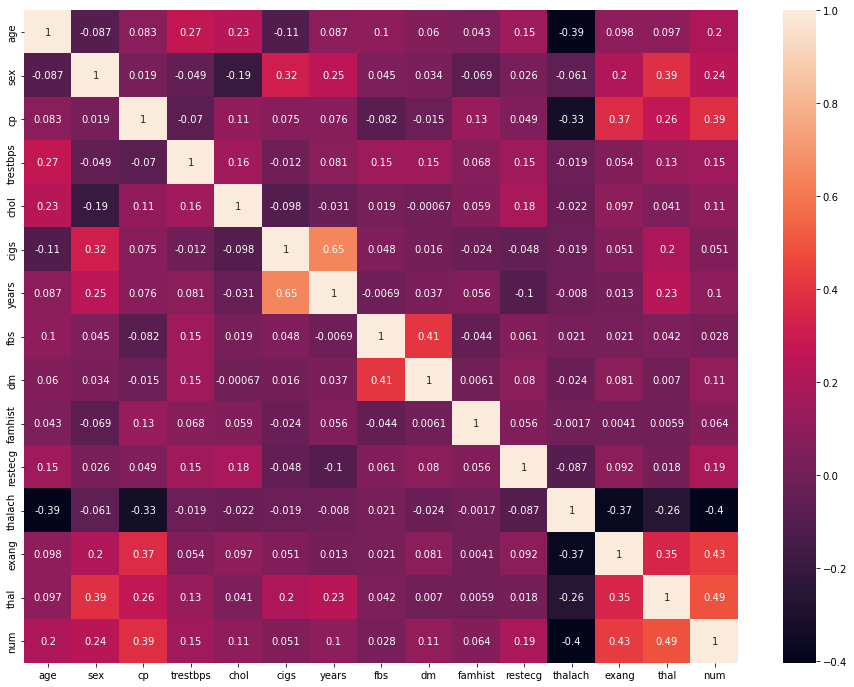

In [4]:
# Correlation Matrix 
corr = df.corr() # show all correlations

plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True)

In the above correlation matrix, the correlations do not appear very strong in the data, indicating independence among the variables with not much to infer regarding trends. The closest correlations are relatively weak among cigarette use and years, which makes sense given these variables are related to smoking. 

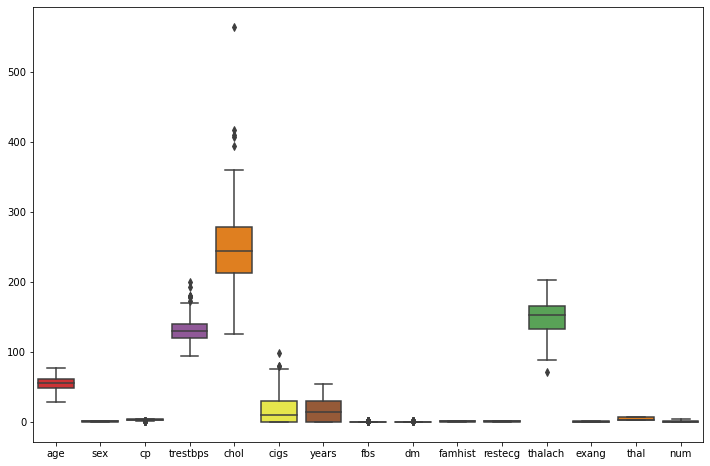

In [5]:
# Box Plot 

plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df, orient="v", palette="Set1")

Albeit removing outliers in the Week 1 portion, I still find outliers persistent which leads me to believe there is a high level of variance in the dataset. Taking a further look, I want to see why cholesterol is so high and what typically constitutes it among the data. 

In [6]:
df.groupby('chol').mean().sort_values('chol', ascending=False).head(10)

,age,sex,cp,trestbps,cigs,years,fbs,dm,famhist,restecg,thalach,exang,thal,num
chol,,,,,,,,,,,,,,
564,67.0,0.0,3.0,115.0,0.0,0.0,0.0,0.0,0.0,2.0,160.0,0.0,7.0,0.0
417,65.0,0.0,3.0,140.0,0.0,0.0,1.0,0.0,0.0,2.0,157.0,0.0,3.0,0.0
409,56.0,0.0,4.0,134.0,0.0,0.0,0.0,0.0,1.0,2.0,150.0,1.0,7.0,2.0
407,63.0,0.0,4.0,150.0,3.0,47.0,0.0,0.0,1.0,2.0,154.0,0.0,7.0,4.0
394,62.0,0.0,4.0,140.0,0.0,0.0,0.0,0.0,1.0,2.0,157.0,0.0,3.0,0.0
360,65.0,0.0,3.0,160.0,0.0,0.0,0.0,0.0,1.0,2.0,151.0,0.0,3.0,0.0
354,57.0,0.0,4.0,120.0,0.0,0.0,0.0,0.0,1.0,0.0,163.0,1.0,3.0,0.0
353,55.0,1.0,4.0,132.0,60.0,30.0,0.0,0.0,1.0,0.0,132.0,1.0,7.0,3.0
341,43.0,0.0,4.0,132.0,40.0,20.0,1.0,0.0,1.0,2.0,136.0,1.0,7.0,2.0


Here, I look at the top 10 cholesterol readings with their respective measurements for the remaining variables. It appears among age, the higher levels of cholesterol appear common. This may have abeen a correlation, however more data would need to be sampled to depict this. Despite inconclusive measure, this is still interesting. We can see how this relationship appears with a bubble plot indicating how these values coincide: 

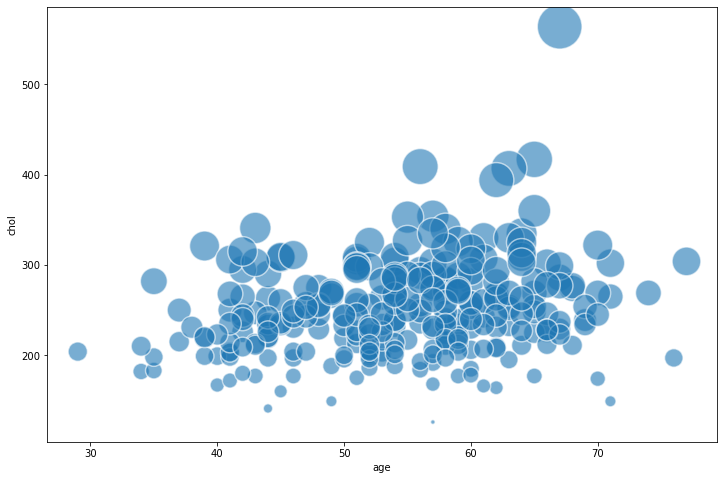

In [7]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x="age", y="chol", size="chol", alpha=.6, edgecolors='gray', legend=False, sizes=(20, 2000))

Here, we can see the distribution is pretty steady as age increases, however some outliers occur between 55-70 years of age. However, this may influence classification in a way that wouldn't detriment my case, given the outliers persist in areas that the most data are present and the variance isn't highly impacted. Just to be sure, I can take a look at variance. 

Levene's test can be used to test out the data from the data that consists of the most outliers. This tests if there is equal variance among variables indiscriminant of high deviations: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html (Note: at the moment this is returning NaN so I used a library called pingouin instead. Source: https://stackoverflow.com/questions/62180386/running-a-levenes-test-over-a-list-instead-of-separate-vectors)

In [8]:
import pingouin as pg

test = pg.homoscedasticity(df, dv='age', group='chol', method='levene', alpha=0.05)
test

,W,pval,equal_var
levene,0.862582,0.805962,True


Here, there is a very high P-Value indicating significance that there are  equal variances, meaning that each variable in fact is not far from the population mean consistently. This means that although each variable is widely varied in its samples, it does not influence the statistical composition of the entire population near its own composition (i.e. skew the mean, median, or standard deviation). 


## Data Preparation

First, I needed to separate the target variable from the data, which is our column "Num". Then, I use a train and test split to divide the data into a training set (80% of the data) and testing set (20% of the data). 

In [9]:
# separate the target variable. any values above 50% are considered diagnosed. Map these values to be: if x < 2 then 0, if x > 2 then 1.
df['num'] = df['num'].apply(lambda x: 1 if x > 2 else 0).astype(int)

x = df.loc[:, (df.columns != 'num')]
y = df['num']

# train and test split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

## Model Build & Evaluation

Using cross-fold validation scoring, I assess the accuracy of the model. I used the KNN model, fit it to the train set, then predicted upon the test set. I scored the tested predictions:

In [10]:
# K-Nearest Neighbors Testing

model = KNN(n_neighbors=1, weights='uniform', p=2)
model = model.fit(x_train, y_train)
predictions = model.predict(x_test)

result = cross_val_score(model, x_test, y_test, cv=5).mean()
"Model Performed with %0.2f accuracy" % result

'Model Performed with 0.71 accuracy'

<Figure size 1152x1152 with 0 Axes>

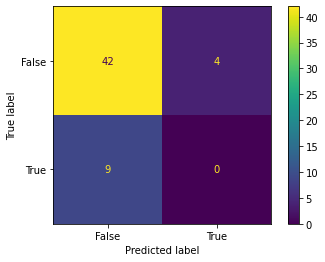

In [11]:
confusion_mtrx = confusion_matrix(y_test, predictions)

plt.figure(figsize=(16,16))
matrix = metrics.ConfusionMatrixDisplay(confusion_mtrx, display_labels=[False, True])
matrix.plot()
plt.show()

In this case, classifying heart disease with KNN would mean the closest distance to points that are considered positive would be positive. The confusion matrix indicates that the true positive values in the upper left are a majority of the data, with some false negatives and fewer false positives. To assess performance, however, seeing the accuracy will help. In this case, only 2/3 of the time is this model accurate. Taking a look at the distribution of values, the cluster while widely varied for positive heart diseases tends to lean toward higher ages at lower cholesterol:

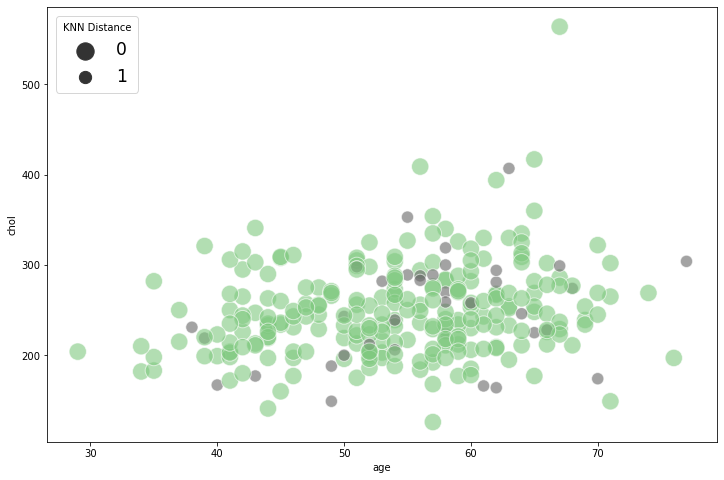

In [12]:
df['predictions'] = model.predict(x)
df['predictions'] = df['predictions'].astype('category')
df['predictions'].cat.codes

ax = plt.figure(figsize=(12,8))
sns.scatterplot(x=df["age"], y=df["chol"], size=df["predictions"].cat.codes, alpha=.6, edgecolors='gray', cmap='Accent', c=df['predictions'].cat.codes, sizes=(150, 300))
plt.legend(title="KNN Distance", loc=2, fontsize='xx-large')


To increase the performance of the model, using more values of K may be experimented with. Since the original target variable ranged from 1-5 and assessed patients by the following: 

<br>

**num: diagnosis of heart disease (angiographic disease status)**
- Value 0: < 50% diameter narrowing
- Value 1: > 50% diameter narrowing

The value of K may be _assumed_ better at 5, however, determining the optimal value of K will best be ascertained from the point at which the model performs at its best. 

In [13]:
model = KNN(n_neighbors=5, weights='uniform', p=2)  # changing to 5 neighbors.
model = model.fit(x_train, y_train)
predictions = model.predict(x_test)

result = cross_val_score(model, x_test, y_test, cv=5).mean()
"Model Performed with %0.2f accuracy" % result

'Model Performed with 0.80 accuracy'

By increasing K to 5, we can see a difference. However, running code to score each cluster until finding the optimal value of K will aid in determining the best value for K: 

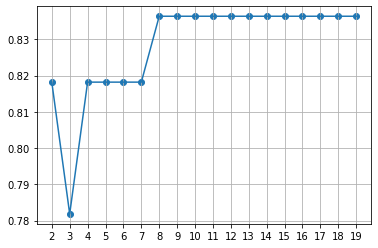

In [14]:
scores = []
for k in range(2, 20):
    # n_jobs=-1 will use all processors on your system
    model = KNN(n_neighbors=k, n_jobs=-1)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    scores.append(accuracy_score(y_test, preds))

# display the resutls
plt.plot(range(2, 20), scores)
plt.scatter(range(2, 20), scores)
plt.grid()
_ =plt.xticks(range(2, 20))

Here, it appears K=8 is most optimal at above 83% accuracy. 

In [15]:
model = KNN(n_neighbors=8, weights='uniform', p=2)  # changing to 8 neighbors.
model = model.fit(x_train, y_train)
predictions = model.predict(x_test)

result = cross_val_score(model, x_test, y_test, cv=5).mean()
"Model Performed with %0.2f accuracy" % result

'Model Performed with 0.84 accuracy'

As expected, the accuracy increased to 84%.

<Figure size 1152x1152 with 0 Axes>

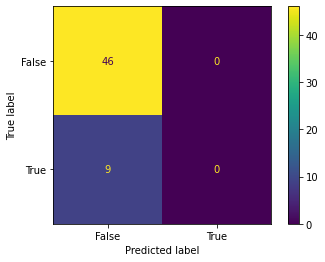

In [16]:
confusion_mtrx = confusion_matrix(y_test, predictions)

plt.figure(figsize=(16,16))
matrix = metrics.ConfusionMatrixDisplay(confusion_mtrx, display_labels=[False, True])
matrix.plot()
plt.show()

In increasing the values of K, the accuracy raised by 4% and the false negative predictions remained the same. However, false positives were removed and true negatives were increased. To best improve this, using cross-validation for feature engineering will increase the score. This will ensure that using folds or computations of randomizing the data are in place to eliminate bias and reduce variance.

In [17]:
# Cross-Validation
from sklearn.model_selection import KFold, RandomizedSearchCV
cv = KFold(n_splits=10, random_state=0, shuffle=True)
after_cv = cross_val_score(model, x_train, y_train, cv=cv).mean()

print("Model Performed with %0.2f accuracy after using cross-validation and increasing to K=8" % after_cv)


Model Performed with 0.85 accuracy after using cross-validation and increasing to K=8


Given cross-validation is applied outside of the model development process, a pipeline would need to be built to perform cross-validation while forming predictions. However, it can be seen it increases the accuracy without over-fitting. In such case we want the best performance, however, we might select an algorithm uniquely designed for our scenario such as another classifier. To improve on this process, I'd likely use more data and try another algorithm like a Logistic Regression or Random Forest. 